L. Drew Hill

CE263N -- Final Project Report



# Introduction
Air pollution is the single biggest environmental risk factor for mortality in the United States ([IHME 2016](https://vizhub.healthdata.org/gbd-compare/)). Exposures to particulate matter less than 2.5 µm in diameter (PM2.5) and ozone alone are estimated to result in about 100,000 US deaths annually. Much work has been done to identify the sources and mitigating factors of such pollution. It now seems that the processes that underlie primary emissions and secondary production of air pollution can be at least partially explained by temporally recurrant social and meteorological phenomenon. My final project leverages the spatial analysis methods learned in this course as well as air quality monitor and weather station data made available by various government bodies to develop a Python class that can model, visualize, and map air quality throughout the San Francisco Bay Area. While multiple spatial Air Quality modelling packages exist, I would like to understand better how one might go about developing such a package for themselves. Thereby, this project does not necesarily add to the field, but does add substantially to my career-relevant skillset and knowledgebase. 


# Methods
## Air Quality Data
The Bay Area Air Quality Management District (BAAQMD), created in 1955, was the first regional air pollution management agency in the country. Over its long history, the BAAQMD has established itself as the leading US regional pollution monitoring and control body. BAAQMD currently uploads, in realtime, data from their National Monitoring System monitors [to the web](http://www.baaqmd.gov/about-air-quality/current-air-quality/air-monitoring-data?DataViewFormat=daily&DataView=aqi&StartDate=12/9/2016&ParameterId=316). Data from each of 17 BAAQMD monitoring locations are uploaded every hour. The BAAQMD makes these data available as raw values for each measured pollutant (PM2.5, ozone, nitrogen dioxide, carbon monoxide, and sulfur dioxide) or as aggregated into a single measure of overall air quality called the Air Quality Index (AQI). Values of the US AQI run from 0 - 300, and describe 'good' (0-50), 'moderate' (51-100), 'unhealthy for sensitive groups' (101-150), 'unhealthy' (151-200), or 'very unhealthy' (201-300) air quality. In most cases, the federal standard for whichever pollutant is contributing most to the index is represented by an AQI of 100. I chose to focus on the AQI, as it is a policy-relevant metric indicative of overall air quality rather than the concentration of a single pollutant.

Hourly average AQI values are uploaded to the BAAQMD Air Monitoring Data website as inputs to an HTML table every hour. This website resets each day, and past pages (with tables) are stored on the BAAQMD.gov server. I have written a Python script to run through this server and scrape 75 days worth of hourly average AQI data leading up to November 31, 2016. This script also appends to the AQI data geotags (as manually extracted or estimated from the [2013 BAAQMD Network Plan](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwj84fe2qOjQAhVJ7WMKHarSB-8QFggcMAA&url=http%3A%2F%2Fwww.baaqmd.gov%2F~%2Fmedia%2FFiles%2FTechnical%2520Services%2F2013_Network_Plan.ashx%3Fla%3Den&usg=AFQjCNHXa4_6y1DnTEBAWML6eR97WN97lg&sig2=wrVEqOy7N9WGkWsleXFoKg)). The data are, together, outputted as a long Pandas dataframe with the following variables: station name, longitude, latitude, hour of the day, average Air Quality Index over that hour, date, and combined date-time. 

## Weather Data
The impact of weather on air pollution concentrations is considerable. For example, when temperatures drop, solid fuel combustion for heating (fireplaces) increases; when temperatures rise and the sun comes out, rates of secondary production of pollution by photocatalysis increase; and when strong winds blow out of the West, pollution from traffic and other sources created in San Francisco is swept across the Bay into the Berkeley and Oakland hills. For this reason, weather data were sought as an important source of features for AQI modeling. 

The US National Oceanic and Atmospheric Administration (NOAA) make federally adminstered weather station data available in near-realtime in the form of text files downloadable from the [Quality Controlled Local Climatological Data server](https://www.ncdc.noaa.gov/qclcd/QCLCD?prior=N). I chose a single station, the Oakland International Airport (OAK), as an indicator of weather conditions in the Bay Area-- the station itself is relatively centrally located within the range of BAAQMD monitoring sites, and is expected to produce high quality data. Hourly weather data for OAK for the months covering the 75 days of AQI data (September, October, and November) were downloaded, cleaned, and loaded into Python as a dataframe. A date-time object was created for each hour. This date-time object was used to merge the AQI and weather dataframes.

## Gaussian Process Regression
### Training and Test Datasets
The merged AQI-weather dataframe ultimately consisted of approximately 35,000 samples, representing 75 days of hourly AQI estimates across 17 air quality monitoring sites and correpsonding regional weather. In some cases, multiple weather measurements were made in the same hour. For this reason, the merge process produced a series of duplicated AQI estimates. These samples were considered still-unique, as the hourly average AQI was representative of the AQI occurring during each correpsonding weather measurement (this may have contributed some bias to the model; testing for such bias was outside the scope of this final project). Training and Test datasets were produced to allow for cross-validation of Gaussian Process bandwidth -- eighty percent of samples were randomly assigned to the Training set, while the remaining twenty percent were assigned to the Test set. 

### Feature Selection
As mentioned in the sections above, temporal social and meteorological phenomenon can help describe a great deal of variation in regional pollution concentrations. For this reason, features for day of the week and hour of the day were produced. From the NOAA datasets, the variables for visibility, dry bulb temperature, wet bulb temperature, relative humidity, wind direction, and station pressure were evaluated. A graphical analysis of bivariate correlations between created features and AQI (demonstrated in the code below) indicated that not all features were useful. Ultimately, longitude, latitude, hour, weekday, visibility, wet bulb temperature, relative humidty, and station pressure were kept as features for the model.

### Model Area
A simple bounding-box-based grid covering all monitoring sites was considered, but was determined too large to reasonably be modeled from the ireregularly spaced network of BAAQMD sites. Instead, a long, asymmetrical polygon more representative of the region coverd by the monitoring network was created and superimposed to the geographic region. This was done by fitting circular buffer zones of 0.28 degrees to each monitoring site, and then fitting a simplified polygon around the buffer borders of all 17 sites. An evenly-distributed grid of 1,037 coordinate points within this polygon was then produced. 


### Class for Modeling and Visualization
A Python class was produced with which one could input historical AQI and weather data for the Bay Area, a relevant modeling area, a Gaussian bandwidth, and a specific date within that range to output a Gaussian Process Model, its one-fold cross-validated performance (r^2), and a modeled map of air quality throughout the prediction polygon for every hour of the specific date of interest. A sub-class was defined that allowed one to input a specific hour of that day to output a KML overlay of the air quality model for that hour of that day. 

This class uses the defined training dataset to produce an sklearn-based Gaussian regression model. The performance of this model is evaluated by predicting AQI on the test data from monitoring sites and comparing it to actual observed AQI data. To model AQI in the Bay Area for the inputted day, this class combines the prediction polygon latitude and longitude coordinates with hourly weather data for the date of interest, creates a feature for time of day, and finally creates a feature for day of the week in order produce a prediction dataset that can be run through the Gaussian Process Model. Images of the modeled data are then plotted across longitude and latitude and colored according to AQI (0-100, where the top of this range indicates air quality that roughly corresponds to levels outside of US regulatory limits).

The cross-validation feature of this class was used to establish an optimal bandwidth. Bandwidths between 0.5 and 0.0001 were evaluated. The optimal bandwidth was chosen using r^2 as the scoring metric: bw = 0.01.


# Results and Conclusions
The Gaussian Process Model predicted AQI in the 20% of randomly excluded 'test' samples with an r^2 of 0.64 and a root mean squared error of 9.5. Predicted versus observed values are plotted in the Code section below. Given this information, it can be determined that the Gaussian Process Model performed reasonably well, especially considering the fact that features consist simply of locally collected weather data, coordinates, and easily crafted temporal features. The class itself also performs its function quite well! As a demonstration of this successful functionality, all 24 hours of November 15, 2016 were modeled and mapped in the Code section below. They are also attached in my submission. Unfortunately, the class takes roughly 9 minutes to initialize on my computer. This is likely a function of the massive dataset I've used to train the model. Perhaps the next evolution of this class should explore the performance of smaller training sets. I also fiddled for a few hours with producing a .gif file in order to produce a loop of Bay Area AQI throughout the day of interest (one frame/map image per hour). However, I was unsuccessful. A future iteration of this class should endeavour more strongly to include such functionality. I should also note that finding the bounding coordinates of the non-rectangular polygon for producing a KML overlay file was a bit tricky; I am unsure of the spatial accuracy of my KML overlay function, though it seems reasonable. Overall, I am quite happy with both the outcome of and my journey with this project.

# Code and visualizations

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cv2
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from descartes.patch import PolygonPatch
from matplotlib.patches import Circle
import datetime
import numpy as np

%matplotlib inline

****Scrape Data from Bay Area Air Quality Management District Tables and Organize HTML Tables and Convert into PD Dataframes**

In [3]:
## list of dates to be included
numdays = 75
dateList = []
base = datetime.datetime(2016, 11,30)
dateList = [base - datetime.timedelta(days=x) for x in range(0, numdays)]

In [4]:
for date in dateList:    
    ## Inputs
    url = 'http://www.baaqmd.gov/about-air-quality/current-air-quality/air-monitoring-data?DataViewFormat=daily&DataView=aqi&StartDate=' + str(date)[0:10] + '&ParameterId=316'

    ## Scrape
    # Scrape the HTML at the url
    r = requests.get(url)
    # crate beautiful soup object
    soup = BeautifulSoup(r.text, 'lxml')
    # Create an object of all HTML tables on the page
    tables = soup.find_all('table')


    ###
    ### Northern Zone
    ###

    # find the table that includes Coast & Central Bay
    # by identifying the table with this name
    td_list = soup.find_all('table')
    i = 0
    for elem in td_list:
        if 'Sebastopol' in elem.text:
            ind = i
        i += 1

    nz_data= tables[ind]

    ## Create dataframe for coastal zone table

    df = []

    for i in xrange(3,8):
        row_marker = 0  
        new_table = pd.DataFrame(columns=range(0,26), index = [i-3]) 
        for row in nz_data.find_all('tr')[0:i]:
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                new_table.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
        # create list of rows
        df.append(new_table)

    # append all rows together
    northern = pd.concat(df)



    ###
    ### Coastal & Central Bay
    ###

    # find the table that includes Coast & Central Bay
    # by identifying the table with this name
    td_list = soup.find_all('table')
    i = 0
    for elem in td_list:
        if 'Oakland' in elem.text:
            ind = i
        i += 1

    coastal_data= tables[ind]

    ## Create dataframe for coastal zone table

    df = []

    for i in xrange(3,9):
        row_marker = 0  
        new_table = pd.DataFrame(columns=range(0,26), index = [i-3]) 
        for row in coastal_data.find_all('tr')[0:i]:
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                new_table.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
        # create list of rows
        df.append(new_table)

    # append all rows together
    coastal = pd.concat(df)



    ###
    ### Eastern Zone
    ###

    # find the table that includes Coast & Central Bay
    # by identifying the table with this name
    td_list = soup.find_all('table')
    i = 0
    for elem in td_list:
        if 'Concord' in elem.text:
            ind = i
        i += 1

    eas_data= tables[ind]

    ## Create dataframe for coastal zone table

    df = []

    for i in xrange(3,5):
        row_marker = 0  
        new_table = pd.DataFrame(columns=range(0,26), index = [i-3]) 
        for row in eas_data.find_all('tr')[0:i]:
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                new_table.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
        # create list of rows
        df.append(new_table)

    # append all rows together
    eastern = pd.concat(df)


    ###
    ### South Central Bay
    ###

    # find the table that includes Coast & Central Bay
    # by identifying the table with this name
    td_list = soup.find_all('table')
    i = 0
    for elem in td_list:
        if 'Redwood' in elem.text:
            ind = i
        i += 1

    red_data= tables[ind]

    ## Create dataframe for coastal zone table

    df = []

    for i in xrange(3,4):
        row_marker = 0  
        new_table = pd.DataFrame(columns=range(0,26), index = [i-3]) 
        for row in red_data.find_all('tr')[0:i]:
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                new_table.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
        # create list of rows
        df.append(new_table)

    # append all rows together
    south_cen = pd.concat(df)


    ###
    ### Santa Clara Valley
    ###

    # find the table that includes Coast & Central Bay
    # by identifying the table with this name
    td_list = soup.find_all('table')
    i = 0
    for elem in td_list:
        if 'Jackson' in elem.text:
            ind = i
        i += 1

    sc_data= tables[ind]

    ## Create dataframe for coastal zone table

    df = []

    for i in xrange(3,6):
        row_marker = 0  
        new_table = pd.DataFrame(columns=range(0,26), index = [i-3]) 
        for row in sc_data.find_all('tr')[0:i]:
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                new_table.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
        # create list of rows
        df.append(new_table)

    # append all rows together
    santaclara = pd.concat(df)


    # ####
    # #### combine all dataframes
    # ####
    baaqmd = pd.concat([northern, coastal, eastern, south_cen, santaclara])

    # set index
    baaqmd.index = range(len(baaqmd))

    # set column names
    baaqmd.columns = ['station'] + range(24) + ['mean']

    # remove odd strings from station name
    baaqmd['station'] = baaqmd['station'].map(lambda x: x.lstrip('\n').rstrip('\n*'))
    
    # produce coordinates for merge
    # manually add columns with lat and longitude
        # taken from the 2013 BAAQMD Network Plan
    blat = [38.310942, 38.273744, 37.972310, 38.403765, 38.102507, 
            37.865000, 37.793624, 37.743065, 37.814781, 37.765946, 
            37.960400, 37.936013, 37.687526, 37.482934, 36.999571, 
            37.348497, 37.338000]
    blon = [-122.296189, -122.274590 ,-122.520004, -122.818294, 
            -122.237976,  -122.303000, -122.263376, -122.169935, 
            -122.282347, -122.399044, -122.356811, -122.026154, 
            -121.784217, -122.203500, -121.574684, -121.894898, 
            -121.850000]
    bsta = [u'Napa', u'Napa Valley College ', u'San Rafael', u'Sebastopol',
         u'Vallejo', u'Berkeley Aquatic Park', u'Laney College Fwy',
         u'Oakland East', u'Oakland West',
         u'San Francisco - Arkansas St.', u'San Pablo - Rumrill', 
         u'Concord', u'Livermore - Rincon Ave.', u'Redwood City',
         u'Gilroy', u'San Jose - Jackson St.', u'San Jose Fwy']
    coordinates = pd.DataFrame({'station': bsta, 'lon': blon, 'lat': blat})    
    
    # merge lon and lat with their respective stations
    baaqmd = baaqmd.merge(coordinates, left_on='station', right_on = 'station')

    ## make long -- remove mean
    baaqmd_long = pd.melt(baaqmd, id_vars=['station','lon','lat'], var_name='hour', value_name='aqi')
    baaqmd_long = baaqmd_long[baaqmd_long.hour != 'mean']
    
    # make date variable
    baaqmd_long['day'] = str(date)[0:10]
    
    # convert hour + day columns into single datetime column for wx 
    # merging purposes; retain individual columsn for prediction
    baaqmd_long['hour'] = baaqmd_long['hour'].astype(str)
    baaqmd_long['datetime'] = baaqmd_long['day'] + ' ' + baaqmd_long['hour'] + ':00'
    
    ## Write to file
    with open('data/baaqmd_long', 'a') as f:
        baaqmd_long.to_csv(f, header = False, index = False)

In [2]:
dt_set1 = pd.read_csv('data/baaqmd_long' ,sep=',', header= 0, names = ['station','lon','lat','hour','aqi','day','datetime'])

In [3]:
## Add features
 # day of the week
for i in range(len(dt_set1)):
    dt_set1.ix[i, 'weekday'] = pd.to_datetime(dt_set1.ix[i, 'datetime']).dayofweek

**Load in NOAA Weather Data**

In [4]:
## Read OAK International Airport Weather data
 # Source NOAA (https://www.ncdc.noaa.gov/qclcd/QCLCD?prior=N)
    # sept, oct, nov
sept = pd.read_csv('data/wx_sept.txt')
octo = pd.read_csv('data/wx_oct.txt')
nove = pd.read_csv('data/wx_nov.txt')
    # concatenate
frames = [sept, octo, nove]
wx = pd.concat(frames)
    #reset index of new dataframe
wx = wx.reset_index(drop=True)

In [5]:
## Remove unwanted rows
wx = wx[['Date','Time','Visibility','DryBulbCelsius','WetBulbCelsius','RelativeHumidity','WindDirection','StationPressure']]

In [6]:
## adjust wx datetime to allow merging; round to nearest hour
for i in range(len(wx)):
    if len(str(wx.loc[i,'Time'])) == 2:
        wx.loc[i, 'datetime'] = str(wx.loc[i,'Date'])[0:4] + '-' + str(wx.loc[i,'Date'])[4:6] + '-' + str(wx.loc[i,'Date'])[6:8] + ' 0' + ':00' 
    if len(str(wx.loc[i,'Time'])) == 3:
        wx.loc[i,'datetime'] = str(wx.loc[i,'Date'])[0:4] + '-' + str(wx.loc[i,'Date'])[4:6] + '-' + str(wx.loc[i,'Date'])[6:8] + ' ' + str(str(wx.loc[i,'Time']))[0:1] + ':00' 
    if len(str(wx.loc[i,'Time'])) == 4:
        wx.loc[i,'datetime'] = str(wx.loc[i,'Date'])[0:4] + '-' + str(wx.loc[i,'Date'])[4:6] + '-' + str(wx.loc[i,'Date'])[6:8] + ' ' + str(str(wx.loc[i,'Time']))[0:2] + ':00'
wx = wx.drop(['Date','Time'], axis=1)

**Feature Selection**

In [7]:
dt = dt_set1.merge(wx, left_on='datetime', right_on = 'datetime')

In [8]:
## Ensure all numeric vars are numeric
    # first remove all non-numeric, unhelpful terms
dt.loc[dt['WetBulbCelsius']=='M', 'WetBulbCelsius'] = ''
dt.loc[dt['RelativeHumidity']=='M', 'RelativeHumidity'] = ''
dt.loc[dt['WindDirection']=='M', 'WindDirection'] = ''
dt.loc[dt['WindDirection']=='VR', 'WindDirection'] = ''
dt.loc[dt['WindDirection']=='VR ', 'WindDirection'] = ''
    # then convert to numeric
dt[['WetBulbCelsius','RelativeHumidity','WindDirection','StationPressure']] = dt[['WetBulbCelsius','RelativeHumidity','WindDirection','StationPressure']].apply(pd.to_numeric)

In [9]:
# drop rows with NA
dt = dt.dropna()

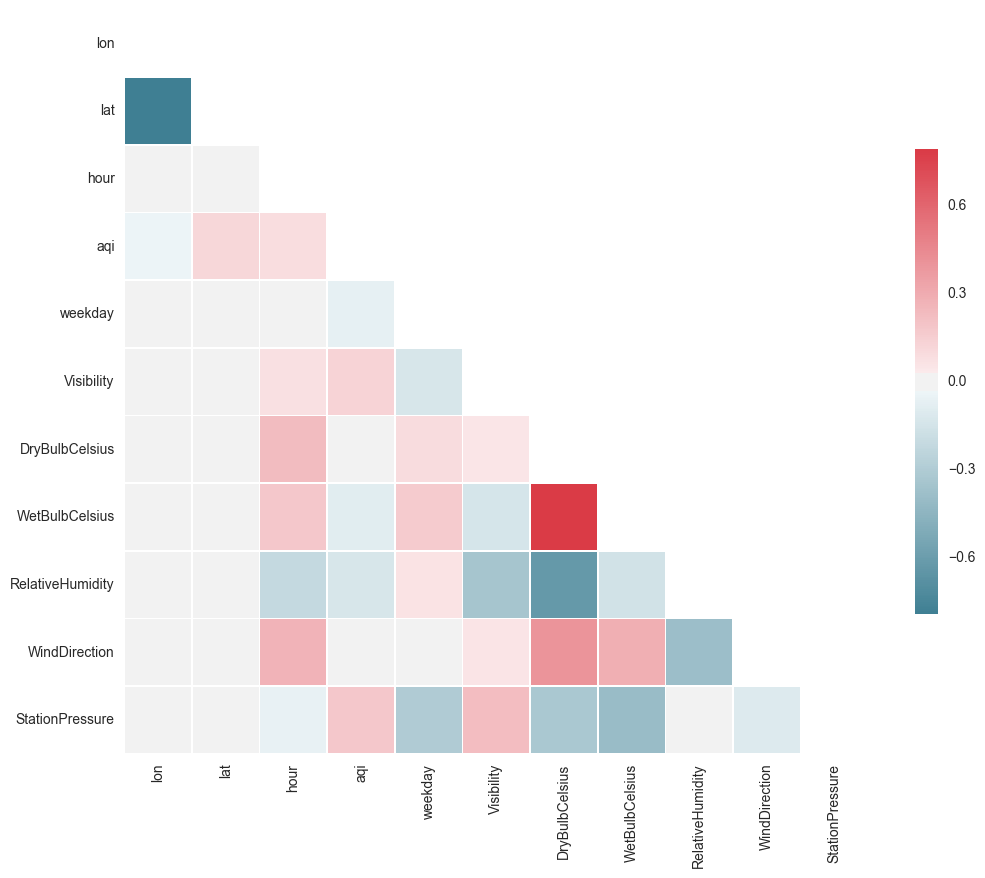

In [10]:
import seaborn as sns

## Correlation matrix of all variables
sns.set(style="white")
corr = dt.corr()

# # Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12)) # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) # setup ticks

plt.xticks(rotation='vertical')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask=mask,vmax=.3, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [11]:
## Individual plots


## Boxplot by hour
dt.boxplot(column='aqi', by = 'hour')

## Boxplot by day of year
dt.boxplot(column='aqi', by = pd.DatetimeIndex(pd.to_datetime(dt['datetime'])).day)

## Boxplot by day of week
dt.boxplot(column='aqi', by = pd.DatetimeIndex(pd.to_datetime(dt['datetime'])).weekday)

## Boxplot by station
dt.boxplot(column='aqi', by = 'station')

## Boxplot by station
dt.boxplot(column='aqi', by = 'Visibility')

## Scatterplot by temp 1
plt.figure(figsize=(6,4))
plt.plot(dt['WetBulbCelsius'],dt['aqi'], '.')
plt.show()

## Scatterplot by temp 2
plt.figure(figsize=(6,4))
plt.plot(dt['DryBulbCelsius'],dt['aqi'], '.')
plt.show()

## Scatterplot by RH
plt.figure(figsize=(6,4))
plt.plot(dt['RelativeHumidity'],dt['aqi'], '.')
plt.show()

## Scatterplot by Wind DIr
plt.figure(figsize=(6,4))
plt.plot(dt['WindDirection'],dt['aqi'], '.')
plt.show()

## Boxplot by Wind DIr
dt.boxplot(column='aqi', by = 'WindDirection')

## histogram of AQI
plt.hist(dt.values[:,4])

In [12]:
## produce dataframe with full set of values (pre-determined)
 # to get an idea of what a single day looks like, and coordinates of all stations
baaqmd = dt.loc[dt['datetime'] == '2016-11-25 0:00']

** Model Area **

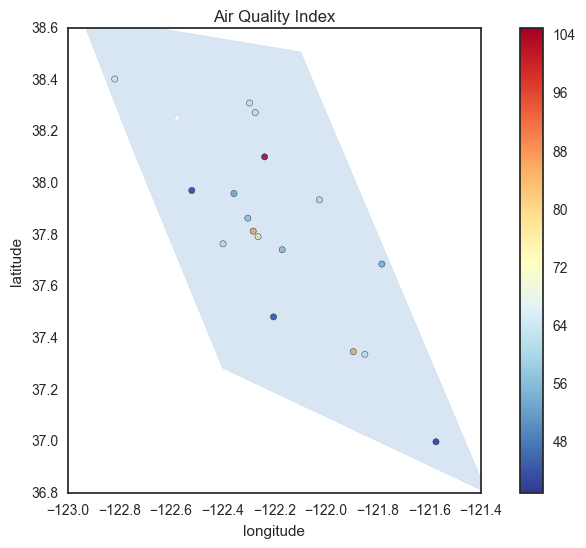

In [13]:
from pylab import *

points1 = MultiPoint(np.array(baaqmd[['lon','lat']]))

fig = plt.figure(1, figsize=(10, 6), dpi=90)
fig.set_frameon(True)

# 1
ax = fig.add_subplot(111)

ax.scatter( x = baaqmd.lon, y = baaqmd.lat,c= baaqmd['aqi'], cmap='RdYlBu_r')
ax.set_aspect(1)

#colors
scalarmappaple = cm.ScalarMappable(
    norm=mcolors.Normalize(vmin=float(baaqmd['aqi'].min()), vmax=float(baaqmd['aqi'].max())),
    cmap='RdYlBu_r')
scalarmappaple.set_array(baaqmd['aqi'])
plt.colorbar(scalarmappaple)

env1 = points1.buffer(0.28).simplify(0.25)
patch1 = PolygonPatch(env1, facecolor='#6699cc', edgecolor='#6699cc', alpha=0.25, zorder=2)
ax.add_patch(patch1)

ax.set_title('Daily Mean AQI by Station')
ax.set_aspect(1)



# labels
xlabel('longitude')
ylabel('latitude')
title('Air Quality Index');

**Make Prediction Polygon for Prediction/Forecasting**

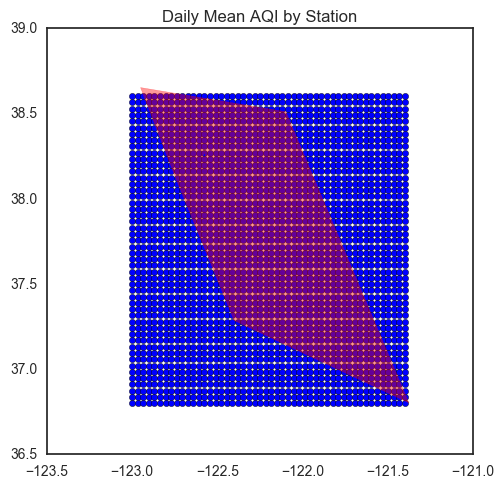

In [14]:
# make rectangular grid with ncell nodes at each dimension
def make_grid(bounding_box, ncell):
    xmax, xmin, ymax, ymin = bounding_box 
    xgrid = np.linspace(xmin, xmax, ncell) 
    ygrid = np.linspace(ymin, ymax, ncell)
    
    mX, mY = np.meshgrid(xgrid, ygrid) 
    ngridX = mX.reshape(ncell*ncell, 1); 
    ngridY = mY.reshape(ncell*ncell, 1);
    
    return np.concatenate((ngridX, ngridY), axis=1)

# make 2500-point grid for prediction (the points upon which we'll predict rain)
bounding_box = [-121.4, -123, 36.8, 38.6]
Xgrid = make_grid(bounding_box, 50)

fig, ax = subplots()
ax.scatter(Xgrid[:,0],Xgrid[:,1])

env1 = points1.buffer(0.28).simplify(0.25)
patch1 = PolygonPatch(env1, facecolor='red', edgecolor='red', alpha=0.4, zorder=2)
ax.add_patch(patch1)

ax.set_title('Daily Mean AQI by Station')
ax.set_aspect(1)

plt.show()

In [15]:
# # convert Xgrid to MultiPoint type
# # grid_points = MultiPoint(Xgrid)

pred_set = np.empty([0,2])

# check to see whether a point is contained in polygon
for i in range(Xgrid.shape[0]):
    if env1.contains(Point(Xgrid[i])) == True:
        pred_set= np.concatenate((pred_set,np.array([Xgrid[i]])))

pred_set = pd.DataFrame(pred_set).rename(columns={0: 'lon', 1: 'lat'})

In [82]:
pred_set

-122.90204081632653

**Create training and test monitor sets**

In [20]:
## create a random index
    # remember 'ba' is the np array I made earlier from baaqmd
import random
approx_frac_picked = 0.8
rand_rows = random.sample(range(len(dt)), int(round(len(dt) * approx_frac_picked,0)))

# select the rows that correspond to random index
trn = dt.loc[rand_rows].dropna()
tst = dt.drop(dt.index[[rand_rows]]).dropna()

** Modeling and visualization class!**

In [88]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cv2
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from descartes.patch import PolygonPatch
from matplotlib.patches import Circle
import datetime
import numpy as np
from pylab import *
import seaborn as sns
import time
from scipy import spatial
from sklearn.gaussian_process import GaussianProcessRegressor
import os.path
import pickle
from sklearn.metrics import mean_squared_error





class aqi_cast:
    
    def __init__(self,bw,train_df,test_df,prediction_polygon_coords_df,wx_df,date_string):
        self.trn = train_df
        self.tst = test_df
        self.pred_set = prediction_polygon_coords_df
        self.bw = bw
        self.date_string = date_string
        self.wx = wx_df
        self.y_train = train_df.values[:,4]
        self.X_train = train_df.values[:,[1,2,3,7,8,9,10,11,12,13]]
        self.y_test = test_df.values[:,4]
        self.X_test = test_df.values[:,[1,2,3,7,8,9,10,11,12,13]]

 
        #Add time (hour and weekday) to pred_set
        self.pred_dflist = []
        for i in range(24):
            self.a = self.pred_set.copy()
            self.a['datetime'] = self.date_string + ' ' + str(0 + i) + ':00'
            self.pred_dflist.append(self.a)
        self.pred_set_time = pd.concat(self.pred_dflist)
        self.pred_set_time = self.pred_set_time.reset_index()
        for i in range(len(self.pred_set_time)):
            self.pred_set_time.ix[i, 'hour'] = pd.to_datetime(self.pred_set_time.ix[i, 'datetime']).hour    
        for i in range(len(self.pred_set_time)):
            self.pred_set_time.ix[i, 'weekday'] = pd.to_datetime(self.pred_set_time.ix[i, 'datetime']).dayofweek

        # Add weather to pred_set
        self.prediction_set = self.pred_set_time.merge(self.wx, left_on='datetime', right_on = 'datetime')
        
        # Rearrange Prediction_Set features to match test/training sets
        self.cols = ['lon','lat','hour','weekday','Visibility','DryBulbCelsius',
                'WetBulbCelsius','RelativeHumidity','WindDirection','StationPressure']
        self.prediction_set = self.prediction_set[self.cols]

        # instanstanciate gp process, and gp fit
        self.gp = GaussianProcessRegressor(alpha = self.bw, normalize_y = True,copy_X_train=False)
        self.gpfit = self.gp.fit(self.trn[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']].values, self.trn['aqi'].values)

        # predict on test set
        self.y_tst_pred = self.gpfit.predict(self.tst[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']].values)

        #r2
        self.score = self.gpfit.score(self.tst[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']].values,self.tst['aqi'].values)
        # predict on polygon samples
        self.X_pred = self.prediction_set[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']].values
        self.y_pred = self.gpfit.predict(self.X_pred)
        self.Xy = np.append(self.prediction_set,self.y_pred[...,None],1)


    def vis_predpolygon(self):
        self.points1 = MultiPoint(np.array(self.tst[['lon','lat']]))
        self.fig, self.ax = subplots()
        self.ax.scatter(self.prediction_set['lon'],self.prediction_set['lat'], alpha=.005)

        self.env1 = points1.buffer(0.28).simplify(0.25)
        self.patch1 = PolygonPatch(self.env1, facecolor='#6699cc', edgecolor='#6699cc', alpha=0.25, zorder=2)
        self.ax.add_patch(self.patch1)

        self.ax.scatter( x = self.tst.lon, y = self.tst.lat,c= self.tst['aqi'], cmap='RdYlBu_r')
        self.ax.set_aspect(1)

        #colors
        self.scalarmappaple = cm.ScalarMappable(
            norm=mcolors.Normalize(vmin=float(self.tst['aqi'].min()), vmax=float(self.tst['aqi'].max())),
            cmap='RdYlBu_r')
        self.scalarmappaple.set_array(self.tst['aqi'])
        plt.colorbar(self.scalarmappaple)

        self.ax.set_title('Daily Mean AQI by Station')
        self.ax.set_aspect(1)

        plt.show()

        
    def gptrain_CV_plot(self, showplot = True):
        self.pred = self.gpfit.predict(self.tst[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']])

        ## CV
        # predict on test set
        self.y_tst_pred = self.gpfit.predict(self.tst[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']].values)

        #r2
        self.score = self.gpfit.score(self.tst[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']].values,self.tst['aqi'].values)

        # RMSE on test data set
        self.RMSE = mean_squared_error(self.tst['aqi'].values, self.y_tst_pred)**0.5
        print 'r2 from random forest regression', round(self.score,4)
        print 'predictive RMSE from random forest regression:', round(self.RMSE,4)
        
        if showplot:
            # Plot observed vs. predicted
            plt.scatter(self.tst['aqi'].values, self.y_tst_pred)
            # m, b = np.polyfit(y_test, y_test_pred, 1)
            # plt.plot(y_test, m*y_test + b, color='red',alpha=0.5)
            # plt.xlim([7,14])
            # plt.ylim([7,14])
            plt.xlabel('Observed AQI')
            plt.ylabel('Predicted AQI')
            plt.title('Gaussian Process Regression\n Observed vs. Predicted')
            plt.plot()
 

    def pred_vis(self):
        # Turn off interactive plotting 
        # (requires manual 'show'ing of plot)
        plt.ioff()
        
        ## Produce Bay Area Model for each hour of the day
        for i in range(24):
            self.hour = float(i)
            self.Xy_plot = self.Xy[self.Xy[:,2] == self.hour]

            ## Plot
            self.fig, self.ax = subplots()
            self.ax.scatter( x = self.Xy_plot[:,0], y = self.Xy_plot[:,1], c=self.Xy_plot[:,10], cmap='RdYlBu_r')
            self.ax.set_aspect(1)

            #colors
            self.scalarmappaple = cm.ScalarMappable(
                norm=mcolors.Normalize(vmin=0, vmax=100),
                cmap='RdYlBu_r')
            self.scalarmappaple.set_array(self.Xy_plot[:,10])
            plt.colorbar(self.scalarmappaple)

            # labels
            xlabel('longitude')
            ylabel('latitude')
            title('AQI')

            savefig('data/sim' + str(self.hour) + '.png', transparent=True);
            
            
            
    def pred_kml_singlehour(self,hour):
        
        self.thishour = float(hour)
        self.Xy_plot = self.Xy[self.Xy[:,2] == self.thishour]

        ## Plot
        self.fig, self.ax = subplots()
        self.ax.scatter( x = self.Xy_plot[:,0], y = self.Xy_plot[:,1], c=self.Xy_plot[:,10], cmap='RdYlBu_r')
        self.ax.set_aspect(1)
        plt.axis('off')

        #colors
        self.scalarmappaple = cm.ScalarMappable(
            norm=mcolors.Normalize(vmin=0, vmax=100),
            cmap='RdYlBu_r')
        self.scalarmappaple.set_array(self.Xy_plot[:,10])

        #remove whitespace around image
        subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                      hspace = 0, wspace = 0)
        margins(0,0)
        gca().xaxis.set_major_locator(NullLocator())
        gca().yaxis.set_major_locator(NullLocator())

        savefig('data/overlayimage' + str(self.thishour) + '.png', transparent=True)

        
        ## open image and create KML
        self.text_file = open("/Users/lawsonhill/Box Sync/Current Coursework/CE263 - Scalable Spatial Analytics/Assignments/Final/data/overlay%s.kml" % str(hour),"w")
            # write to that file
        self.text_file.write("""<?xml version="1.0" encoding="UTF-8"?>
        <kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
        <GroundOverlay>
            <name>Final Proj overlay</name>
            <color>dbffffff</color>
            <Icon>
                <href>/Users/lawsonhill/Box Sync/Current Coursework/CE263 - Scalable Spatial Analytics/Assignments/Final/data/overlayimage%s.0.png</href>
                <viewBoundScale>0.75</viewBoundScale>
            </Icon>
            <LatLonBox>
                <north>39.1</north>
                <south>36.5</south>
                <east>-121.0</east>
                <west>-123.5</west>
            </LatLonBox>
        </GroundOverlay>
        </kml>""" % str(hour))
            # close file
        self.text_file.close()

In [89]:
# runtime ~ 500 seconds
start = time.time()
cast = aqi_cast(bw = 0.01, train_df=trn, test_df=tst,prediction_polygon_coords_df=pred_set, wx_df=wx, date_string='2016-11-15')
end = time.time()
print(end-start)

554.217386961


r2 from random forest regression 0.638
predictive RMSE from random forest regression: 9.5418


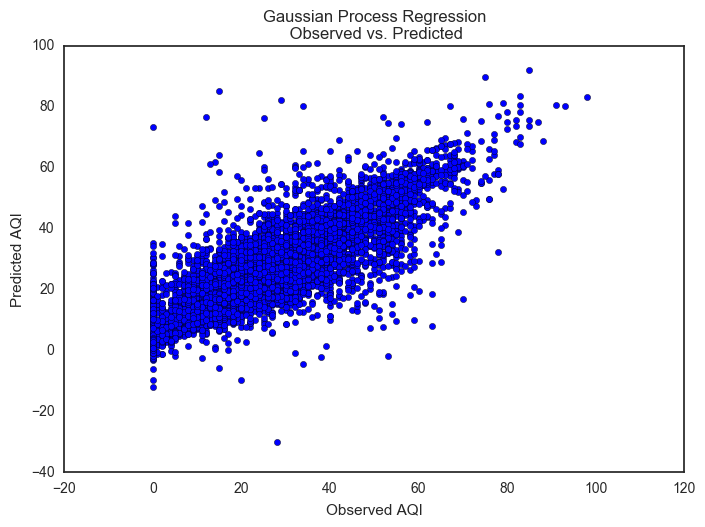

In [90]:
cast.gptrain_CV_plot(showplot=True)

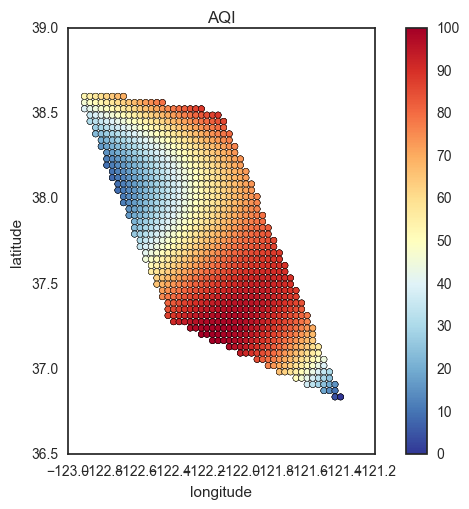

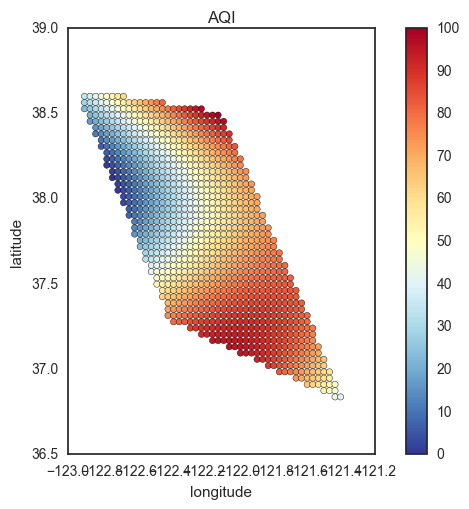

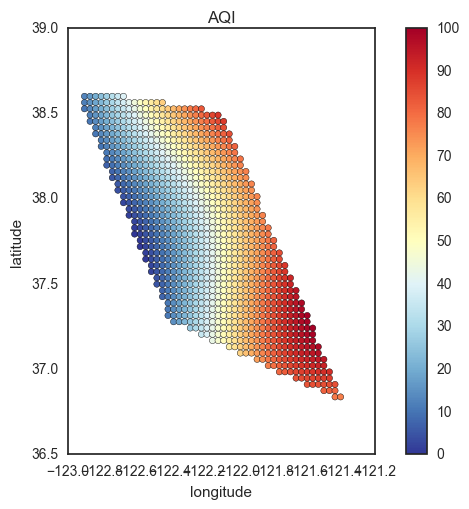

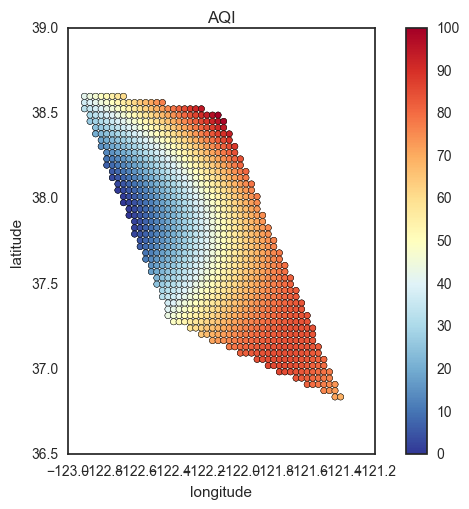

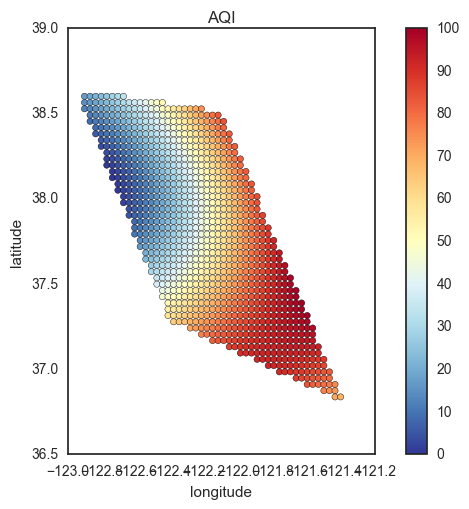

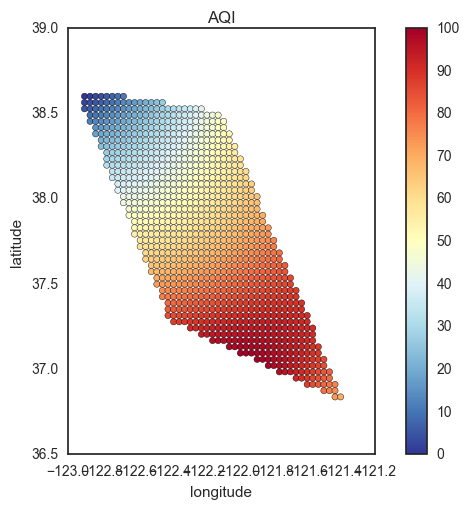

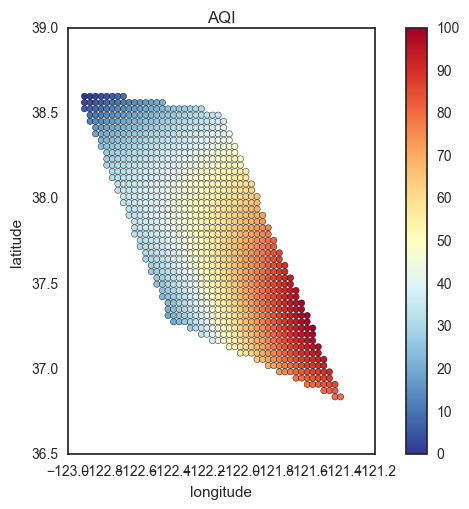

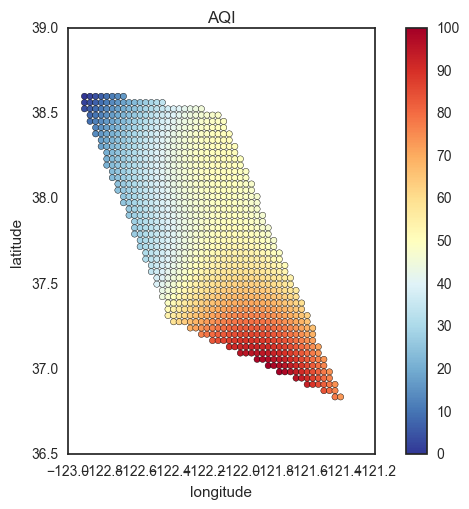

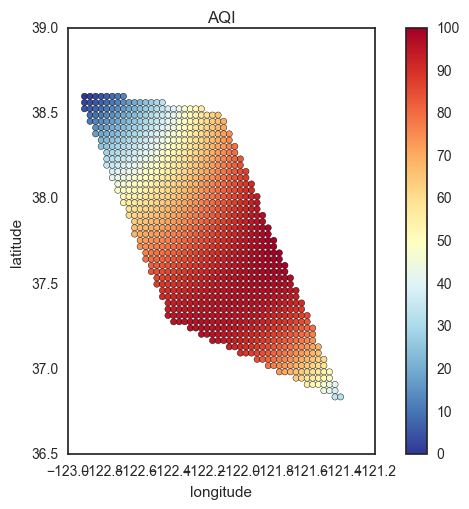

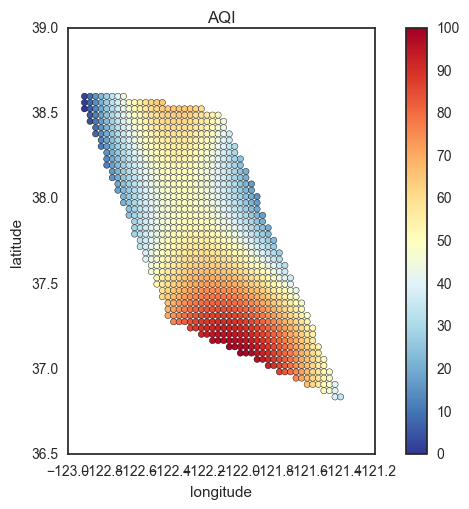

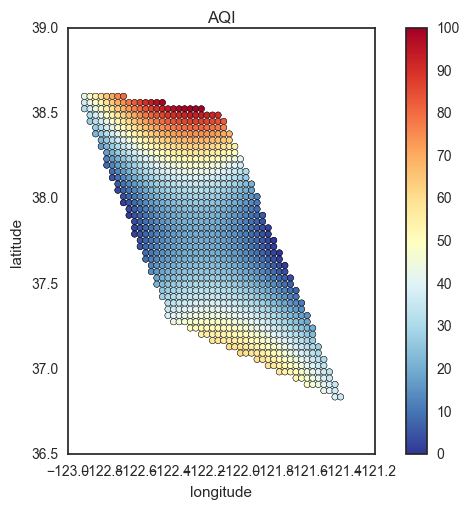

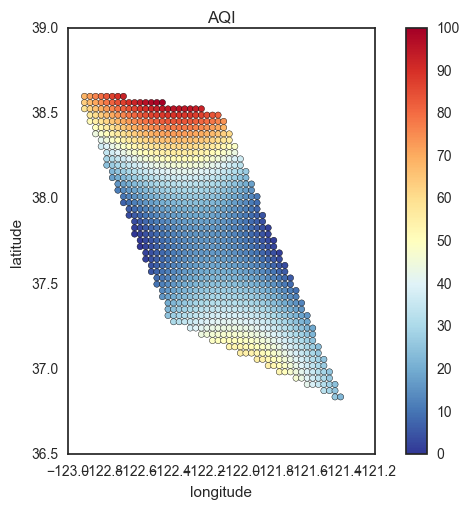

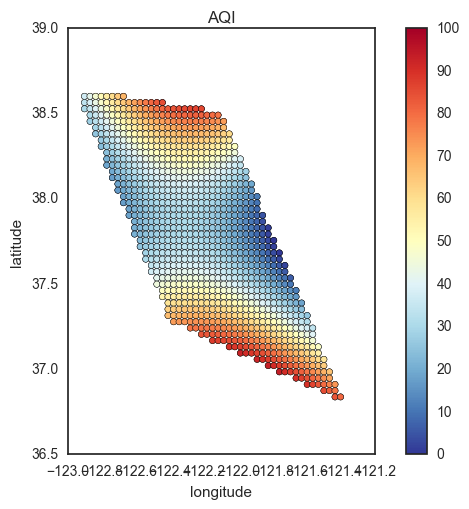

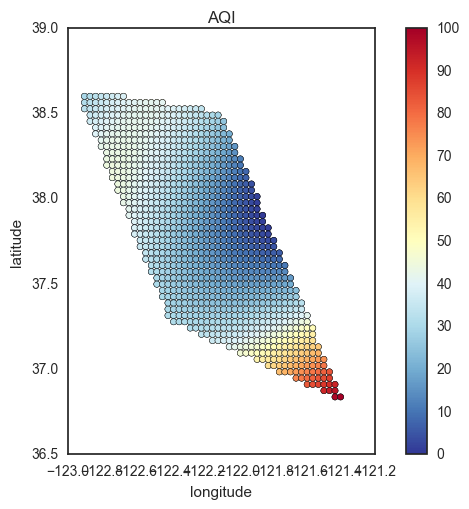

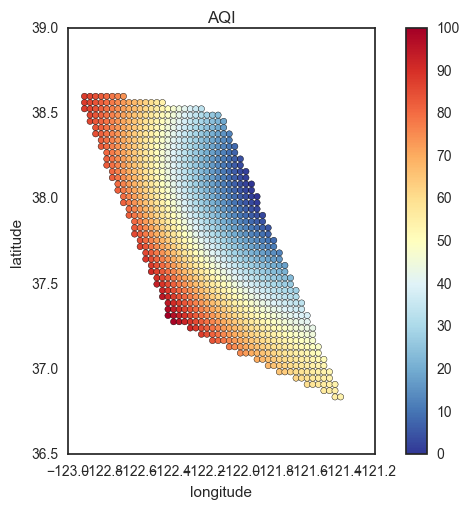

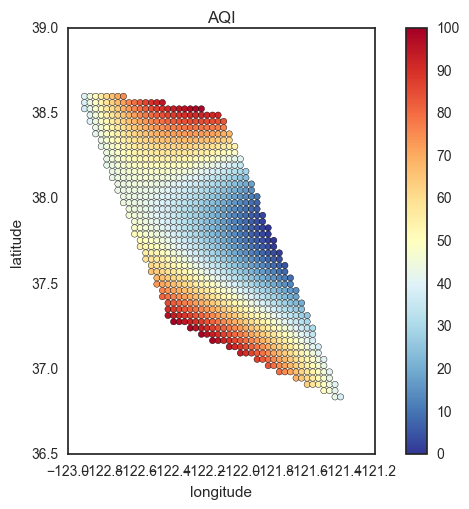

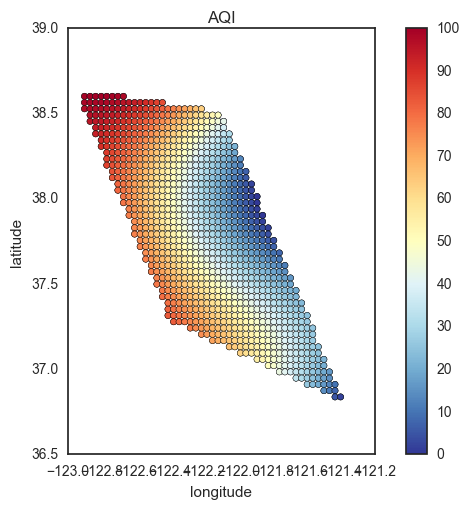

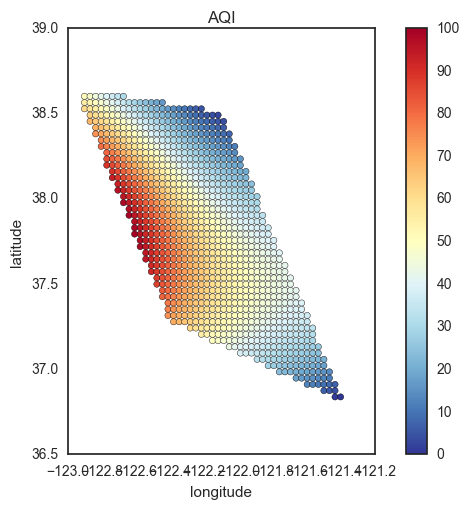

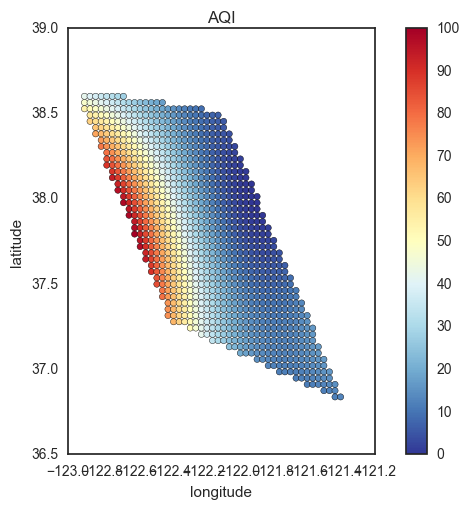

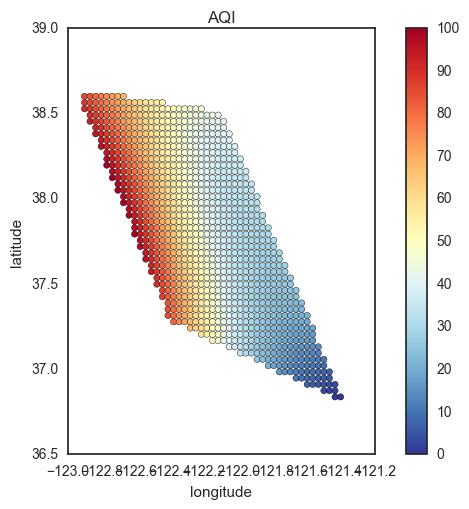

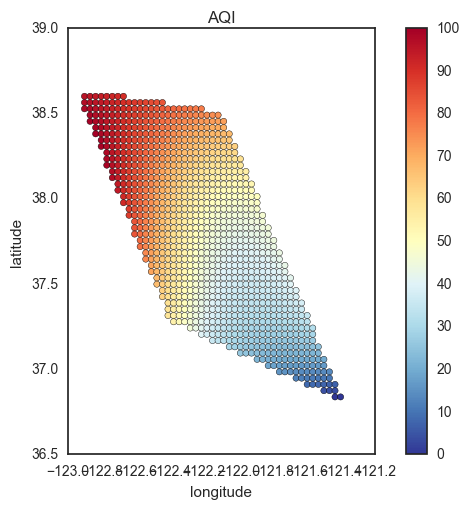

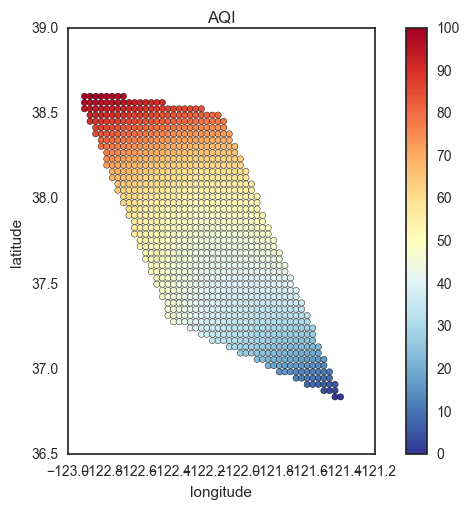

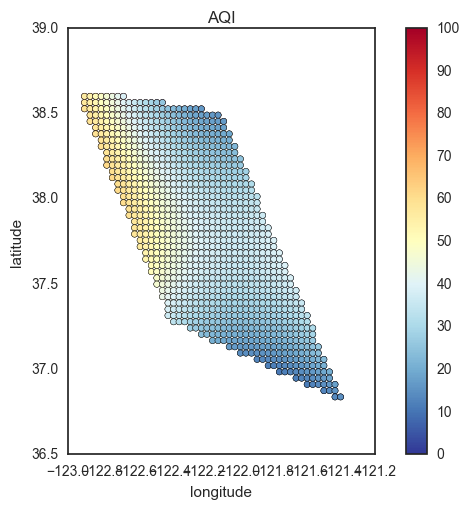

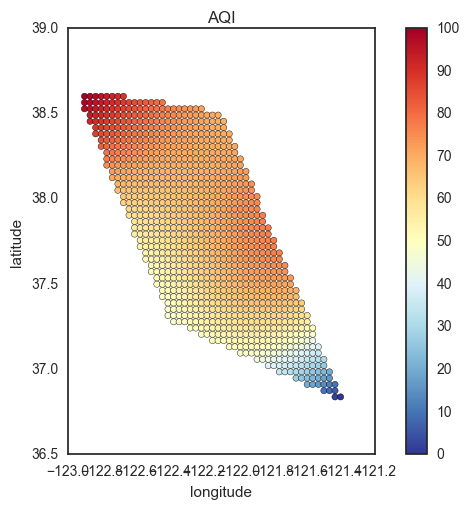

In [91]:
cast.pred_vis()

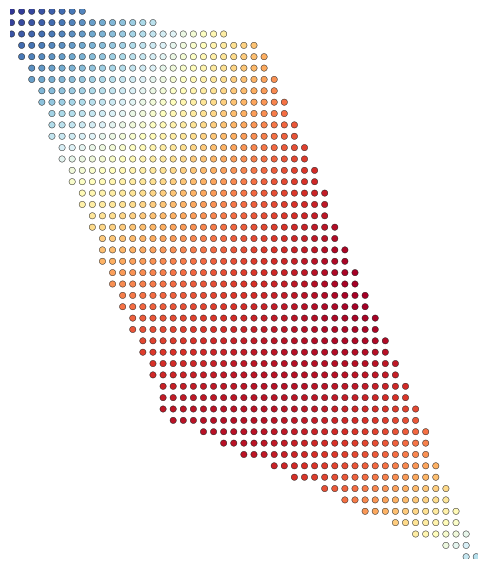

In [92]:
cast.pred_kml_singlehour(8)

**Cross-validation to find best bw**

In [75]:
## Loop to mathematically determine best bandwidth 
## using cross-validation (20% testing sample)

# create array
cv_bw = np.empty((0,2), float64)

# append to it
for i in [0.0001, 0.005, 0.001, 0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.11, 0.13, 0.15]:
    cast = aqi_cast(bw = i, train_df=trn, test_df=tst,prediction_polygon_coords_df=pred_set, wx_df=wx, date_string='2016-11-15')
    a = cast.gpfit.score(cast.tst[['lon','lat','hour','weekday','Visibility','WetBulbCelsius','RelativeHumidity','StationPressure']].values,cast.tst['aqi'].values)
    b = np.array([[i,a]])
    cv_bw = np.append(cv_bw, b ,axis=0)

# print maximum (BW = .01, r2 = 0.638)
cv_bw[np.argmax(cv_bw[:,1])]